<h1 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h1>

<h2 style="text-align: center;"><b>Семестр 1 Осень 2025 года. Финальный проект. Geometry ML</b></h2>


**Выполил:** Емельянов Евгений  
**Stepik ID:** https://stepik.org/users/37851967  
**TG:** evg_em

<h2 style="text-align: center;"><b>Часть 3. Решение задачи классификации графов с помощью Graph Neural Network</b></h2>

# Предварительные процедуры

## Загрузка библиотек

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, precision_score, recall_score
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
import pickle
warnings.filterwarnings('ignore')

In [4]:
class GeometricMLPipeline:
   
    def __init__(self, embedding_dim=64, hidden_dim=128, heads=4, dropout=0.2):
        self.embedding_dim = embedding_dim  
        self.hidden_dim = hidden_dim
        self.heads = heads
        self.dropout = dropout

        self.results = {
            'baseline': {'metrics': {}, 'models': {}, 'embeddings': {}},
            'enriched': {'metrics': {}, 'models': {}, 'embeddings': {}}
        }
        
    def prepare_pca_embeddings(self, enriched_ego_network):
        print("=" * 70)
        print("Создание PCA-эмбеддингов из исходных признаков")
        print("=" * 70)
        
        all_raw_features = []
        ego_info = []  
        
        for ego_id, data in enriched_ego_network.items():
            if 'node_features_raw' in data and data['node_features_raw'] is not None:
                features = data['node_features_raw']
                all_raw_features.append(features)
                ego_info.extend([(ego_id, i) for i in range(features.shape[0])])
                
        max_dim = max(f.shape[1] for f in all_raw_features)
        print(f"Максимальная размерность: {max_dim}")
        
        features_padded = []
        for features in all_raw_features:
            if features.shape[1] < max_dim:
                padded = np.pad(features, ((0, 0), (0, max_dim - features.shape[1])), mode='constant', constant_values=0)
                features_padded.append(padded)
            else:
                features_padded.append(features)
        
        X_all = np.vstack(features_padded)
        print(f"Общий размер данных для PCA: {X_all.shape}")

        pca = PCA(n_components=self.embedding_dim)
        X_pca = pca.fit_transform(X_all)
        print(f"Размерность после PCA: {X_pca.shape[1]}")
        
        start_idx = 0
        pca_embeddings = {}
        
        for ego_id, data in enriched_ego_network.items():
            if 'node_features_raw' in data and data['node_features_raw'] is not None:
                n_nodes = data['node_features_raw'].shape[0]
                pca_embeddings[ego_id] = X_pca[start_idx:start_idx + n_nodes]
                start_idx += n_nodes
        
        return pca_embeddings, pca
    
    def split_ego_networks(self, ego_ids, train_ratio=0.7, val_ratio=0.15, random_state=42):
        np.random.seed(random_state)
        shuffled_ids = np.random.permutation(ego_ids)
        
        n_train = int(len(shuffled_ids) * train_ratio)
        n_val = int(len(shuffled_ids) * val_ratio)
        
        train_ids = shuffled_ids[:n_train]
        val_ids = shuffled_ids[n_train:n_train + n_val]
        test_ids = shuffled_ids[n_train + n_val:]
        
        print(f"\nРазделение ego-networks:")
        print(f"  Train: {len(train_ids)} сетей: {train_ids}")
        print(f"  Val: {len(val_ids)} сетей: {val_ids}")
        print(f"  Test: {len(test_ids)} сетей: {test_ids}")
        
        return train_ids, val_ids, test_ids


    # создание матрицы признаков
    def create_feature_matrices(self, enriched_ego_network, pca_embeddings, mode='baseline'):
        feature_matrices = {}
        
        for ego_id, data in enriched_ego_network.items():
            if ego_id not in pca_embeddings:
                continue
            
            pca_base = pca_embeddings[ego_id]  
            n_nodes_full = pca_base.shape[0]
            
            if mode == 'baseline':
                X = pca_base
                
            # enriched             
            else:
                components = [pca_base]
                feature_types = ['structural_features', 'global_features', 'local_features']
                
                for feat_type in feature_types:
                    if feat_type in data:
                        features = data[feat_type]  

                        if features.shape[0] < n_nodes_full:
                            n_features = features.shape[1]
                            padded_features = np.zeros((n_nodes_full, n_features), dtype=np.float64)
                                                        
                            padded_features[:features.shape[0], :] = features
                            components.append(padded_features)
                        else:
                            components.append(features)
                
                try:
                    X = np.hstack(components)
                except ValueError as e:
                    print(f"Ошибка при объединении признаков для ego {ego_id}: {e}")
                    print(f"Размерности компонентов: {[c.shape for c in components]}")
          
            feature_matrices[ego_id] = X             
        return feature_matrices


    # создание multi-label матрицы
    def create_labels(self, enriched_ego_network):

        label_matrices = {}
        label_info = {}
        
        for ego_id, data in enriched_ego_network.items():
            circles = data.get('circles', {})
            if not circles:
                continue
            
            if 'node_ids' in data:
                node_ids = data['node_ids']
            else:
                node_ids = list(data['graph'].nodes())
            
            node_to_idx = {node: idx for idx, node in enumerate(node_ids)}

            circle_names = list(circles.keys())
            circle_to_idx = {name: idx for idx, name in enumerate(circle_names)}

            Y = np.zeros((len(node_ids), len(circle_names)), dtype=np.float32)
            
            for circle_name, members in circles.items():
                circle_idx = circle_to_idx[circle_name]
                for member in members:
                    if member in node_to_idx:
                        Y[node_to_idx[member], circle_idx] = 1.0
            
            label_matrices[ego_id] = Y
            label_info[ego_id] = {
                'circle_names': circle_names,
                'num_circles': len(circle_names),
                'node_ids': node_ids
            }        
        return label_matrices, label_info


        
    # подготовка данные в PyTorch Geometric
    def prepare_pyg_data(self, feature_matrices, label_matrices, enriched_ego_network, ego_ids):
        data_dict = {}
                
        max_classes = 0
        for ego_id in ego_ids:
            if ego_id in label_matrices:
                max_classes = max(max_classes, label_matrices[ego_id].shape[1])
        
        print(f"Максимальное количество кругов среди всех сетей: {max_classes}")
        
        for ego_id in ego_ids:
            if ego_id not in feature_matrices or ego_id not in label_matrices:
                continue
            
            X = feature_matrices[ego_id]
            Y = label_matrices[ego_id]
            
            # дополняем матрицу меток до максимальной размерности 0
            if Y.shape[1] < max_classes:
                Y_padded = np.pad(Y, ((0, 0), (0, max_classes - Y.shape[1])), mode='constant', constant_values=0)
            else:
                Y_padded = Y
            
            # edgeIndex из графа
            G = enriched_ego_network[ego_id]['graph']
            node_list = list(G.nodes())
            node_to_idx = {node: idx for idx, node in enumerate(node_list)}
            
            edge_index = []
            for u, v in G.edges():
                edge_index.append([node_to_idx[u], node_to_idx[v]])
            
            edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
            
            scaler = StandardScaler()
            X_normalized = scaler.fit_transform(X)
            
            data_dict[ego_id] = {
                'x': torch.tensor(X_normalized, dtype=torch.float),
                'y': torch.tensor(Y_padded, dtype=torch.float),  
                'edge_index': edge_index,
                'num_nodes': X.shape[0],
                'num_features': X.shape[1],
                'num_classes': Y.shape[1],  
                'max_classes': max_classes, 
                'original_y_shape': Y.shape,
                'scaler': scaler
            }
        return data_dict



    # GAT for multi-label classification
    # https://arxiv.org/pdf/1710.10903
    class GATMultiLabel(nn.Module):
        def __init__(self, num_features, hidden_dim, max_classes, heads, dropout):
            super().__init__()
            self.conv1 = GATConv(num_features, hidden_dim, heads=heads, dropout=dropout)
            self.conv2 = GATConv(hidden_dim * heads, hidden_dim, heads=1, dropout=dropout, concat=False)
            self.lin = nn.Linear(hidden_dim, max_classes)
            self.dropout = dropout
            
        def forward(self, x, edge_index):
            x = F.relu(self.conv1(x, edge_index))
            x = F.dropout(x, p=self.dropout, training=self.training)
            x = F.relu(self.conv2(x, edge_index))
            x = F.dropout(x, p=self.dropout, training=self.training)
            x = self.lin(x)
            return torch.sigmoid(x)


    
    def train_model(self, model, data_dict, train_ids, val_ids, epochs=200, lr=0.005, weight_decay=5e-4, patience=20):
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = nn.BCELoss()
        
        best_val_loss = float('inf')
        patience_counter = 0
        best_model_state = None
        
        train_history = {'loss': [], 'val_loss': [], 'f1': [], 'val_f1': []}
        
        print(f"\nTrain Model")
        for epoch in tqdm(range(epochs)):
            model.train()
            total_loss = 0
            total_batches = 0
            
            for ego_id in train_ids:
                if ego_id not in data_dict:
                    continue
                
                data = data_dict[ego_id]
                optimizer.zero_grad()
                
                out = model(data['x'], data['edge_index'])
                loss = criterion(out, data['y'])
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
                total_batches += 1
            
            avg_train_loss = total_loss / total_batches if total_batches > 0 else 0

            model.eval()
            val_loss = 0
            val_batches = 0
            
            with torch.no_grad():
                for ego_id in val_ids:
                    if ego_id not in data_dict:
                        continue
                    
                    data = data_dict[ego_id]
                    out = model(data['x'], data['edge_index'])
                    loss = criterion(out, data['y'])
                    val_loss += loss.item()
                    val_batches += 1
            
            avg_val_loss = val_loss / val_batches if val_batches > 0 else 0
            
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                patience_counter = 0
                best_model_state = model.state_dict().copy()
            else:
                patience_counter += 1

            train_history['loss'].append(avg_train_loss)
            train_history['val_loss'].append(avg_val_loss)
            
            if patience_counter >= patience:
                print(f"Ранний стоп на {epoch} эпохе")
                break
        
        if best_model_state:
            model.load_state_dict(best_model_state)        
        return model, train_history


        
    # оценка модели на test ego-networks 
    def evaluate_model(self, model, data_dict, test_ids, threshold=0.5):
        model.eval()
        
        all_metrics = []
        
        with torch.no_grad():
            for ego_id in test_ids:
                if ego_id not in data_dict:
                    continue
                
                data = data_dict[ego_id]
                pred = model(data['x'], data['edge_index'])
                
                # Диагностика
                print(f"\n  Диагностика для Ego {ego_id}:")
                print(f"    Min prediction: {pred.min().item():.4f}")
                print(f"    Max prediction: {pred.max().item():.4f}")
                print(f"    Mean prediction: {pred.mean().item():.4f}")
                print(f"    Predictions > 0.5: {(pred > 0.5).sum().item()}")
                

                best_f1 = 0
                best_threshold = threshold
                
                for th in [0.1, 0.2, 0.3, 0.4, 0.5]:
                    pred_binary = (pred > th).float()
                    num_real_classes = data['num_classes']
                    pred_cropped = pred_binary[:, :num_real_classes]
                    labels_cropped = data['y'][:, :num_real_classes]
                    
                    try:
                        f1 = f1_score(labels_cropped.cpu().numpy(), pred_cropped.cpu().numpy(), average='micro', zero_division=0)
                        
                        if f1 > best_f1:
                            best_f1 = f1
                            best_threshold = th
                    except:
                        continue
                
                print(f"    Лучший порог: {best_threshold}, F1: {best_f1:.4f}")
                
                pred_binary = (pred > best_threshold).float()
                num_real_classes = data['num_classes']
                pred_cropped = pred_binary[:, :num_real_classes]
                labels_cropped = data['y'][:, :num_real_classes]
                
                predictions = pred_cropped.cpu().numpy()
                labels = labels_cropped.cpu().numpy()
                
                try:
                    metrics = {
                        'micro_f1': f1_score(labels, predictions, average='micro', zero_division=0),
                        'macro_f1': f1_score(labels, predictions, average='macro', zero_division=0),
                        'micro_precision': precision_score(labels, predictions, average='micro', zero_division=0),
                        'micro_recall': recall_score(labels, predictions, average='micro', zero_division=0),
                        'samples': len(predictions),
                        'ego_id': ego_id,
                        'num_classes': num_real_classes,
                        'best_threshold': best_threshold
                    }
                    all_metrics.append(metrics)
                    
                    print(f"    Micro F1: {metrics['micro_f1']:.4f}, "
                          f"Macro F1: {metrics['macro_f1']:.4f}")
                    
                except Exception as e:
                    print(f"    Ошибка при вычислении метрик: {e}")
        
        if not all_metrics:
            return {}

        avg_metrics = {
            'micro_f1': np.mean([m['micro_f1'] for m in all_metrics]),
            'macro_f1': np.mean([m['macro_f1'] for m in all_metrics]),
            'micro_precision': np.mean([m['micro_precision'] for m in all_metrics]),
            'micro_recall': np.mean([m['micro_recall'] for m in all_metrics]),
            'total_samples': sum(m['samples'] for m in all_metrics),
            'num_test_networks': len(all_metrics),
            'per_network_metrics': all_metrics
        }        
        return avg_metrics


        
    def run_experiment(self, enriched_ego_network, train_ids, val_ids, test_ids):
        print("=" * 70)
        print("Запуск эксперимента")
        print("=" * 70)
        
        # 1 PCA-embeddings
        pca_embeddings, pca_model = self.prepare_pca_embeddings(enriched_ego_network)
        
        # 2 метки
        label_matrices, label_info = self.create_labels(enriched_ego_network)
        
        # 3 baseline 
        print("\n" + "=" * 70)
        print("Эксперимент 1: Baseline ")
        print("=" * 70)

        baseline_features = self.create_feature_matrices(enriched_ego_network, pca_embeddings, mode='baseline')
        

        baseline_data = self.prepare_pyg_data(baseline_features, label_matrices, enriched_ego_network, 
                                              list(enriched_ego_network.keys()))
        
        sample_ego = list(baseline_features.keys())[0]
        baseline_dim = baseline_features[sample_ego].shape[1]
        num_classes = label_matrices[sample_ego].shape[1]
        max_classes = 0
        for ego_id in enriched_ego_network.keys():
            if ego_id in label_matrices:
                max_classes = max(max_classes, label_matrices[ego_id].shape[1])
        
        print(f"Максимальное количество кругов: {max_classes}")
        
        # Создаём и обучаем baseline модель с учетом max_classes
        baseline_model = self.GATMultiLabel(baseline_dim, self.hidden_dim, max_classes, self.heads, self.dropout)       
      
        baseline_model, baseline_history = self.train_model(baseline_model, baseline_data, train_ids, val_ids)        
        
        # оценка
        baseline_metrics = self.evaluate_model(baseline_model, baseline_data, test_ids)
        
        self.results['baseline']['metrics'] = baseline_metrics
        self.results['baseline']['model'] = baseline_model
        self.results['baseline']['history'] = baseline_history
        self.results['baseline']['pca_model'] = pca_model

        
        print(f"\nРезультаты Baseline:")
        for metric, value in baseline_metrics.items():
            if metric == 'per_network_metrics':
                continue  # Пропускаем список детальных метрик
            elif isinstance(value, (int, float)):
                print(f"  {metric}: {value:.4f}")
            else:
                print(f"  {metric}: {value}")
        
        # 4 ОБогащенная
        print("\n" + "=" * 70)
        print("Эксперимент 2: Enricher with TDA-Results Model")
        print("=" * 70)
        
        enriched_features = self.create_feature_matrices(enriched_ego_network, pca_embeddings, mode='enriched')

        enriched_data = self.prepare_pyg_data(enriched_features, label_matrices, enriched_ego_network,
                                              list(enriched_ego_network.keys()))

        enriched_dim = enriched_features[sample_ego].shape[1]
        
        max_classes = 0
        for ego_id in enriched_ego_network.keys():
            if ego_id in label_matrices:
                max_classes = max(max_classes, label_matrices[ego_id].shape[1])
        
        print(f"Максимальное количество кругов: {max_classes}")
        sample_ego = list(enriched_features.keys())[0]
        enriched_dim = enriched_features[sample_ego].shape[1]

        enriched_model = self.GATMultiLabel(enriched_dim, self.hidden_dim, max_classes, self.heads, self.dropout)      
        
        enriched_model, enriched_history = self.train_model(enriched_model, enriched_data, train_ids, val_ids)

        enriched_metrics = self.evaluate_model(enriched_model, enriched_data, test_ids)       
        
        self.results['enriched']['metrics'] = enriched_metrics
        self.results['enriched']['model'] = enriched_model
        self.results['enriched']['history'] = enriched_history
        
        print(f"\nРезультаты Обогащённой модели:")
        for metric, value in enriched_metrics.items():
            if metric == 'per_network_metrics':
                continue
            elif isinstance(value, (int, float)):
                print(f"  {metric}: {value:.4f}")
            else:
                print(f"  {metric}: {value}")
        
        return self.results
       
    
    def visualize_results(self):

        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        
        # 1. Сравнение метрик
        metrics_to_compare = ['micro_f1', 'macro_f1', 'micro_precision', 'micro_recall']
        
        baseline_vals = [self.results['baseline']['metrics'].get(m, 0) for m in metrics_to_compare]
        enriched_vals = [self.results['enriched']['metrics'].get(m, 0) for m in metrics_to_compare]
        
        x = np.arange(len(metrics_to_compare))
        width = 0.35
        
        ax = axes[0, 0]
        ax.bar(x - width/2, baseline_vals, width, label='Baseline', alpha=0.8)
        ax.bar(x + width/2, enriched_vals, width, label='Enriched', alpha=0.8)
        ax.set_xlabel('Метрики')
        ax.set_ylabel('Значение')
        ax.set_title('Сравнение метрик Baseline vs Enriched')
        ax.set_xticks(x)
        ax.set_xticklabels(metrics_to_compare, rotation=45)
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 2. Кривые обучения Baseline
        ax = axes[0, 1]
        if 'history' in self.results['baseline']:
            history = self.results['baseline']['history']
            ax.plot(history['loss'], label='Train Loss', alpha=0.8)
            ax.plot(history['val_loss'], label='Val Loss', alpha=0.8)
            ax.set_xlabel('Эпоха')
            ax.set_ylabel('Loss')
            ax.set_title('Кривые обучения: Baseline')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        # 3. Кривые обучения Enriched
        ax = axes[0, 2]
        if 'history' in self.results['enriched']:
            history = self.results['enriched']['history']
            ax.plot(history['loss'], label='Train Loss', alpha=0.8)
            ax.plot(history['val_loss'], label='Val Loss', alpha=0.8)
            ax.set_xlabel('Эпоха')
            ax.set_ylabel('Loss')
            ax.set_title('Кривые обучения: Enriched')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        # 4. Размерности признаков
        ax = axes[1, 0]
        if 'baseline' in self.results and 'enriched' in self.results:
            dims = ['Baseline', 'Enriched']
            # Здесь нужно получить реальные размерности
            # Для примера используем placeholder значения
            feature_dims = [64, 64 + 4 + 5 + 3]  # PCA(64) + structural(4) + global(5) + local(3)
            ax.bar(dims, feature_dims, alpha=0.8)
            ax.set_ylabel('Размерность признаков')
            ax.set_title('Размерность пространства признаков')
            ax.grid(True, alpha=0.3)

            for i, v in enumerate(feature_dims):
                ax.text(i, v + 1, str(v), ha='center')
        
        # 5. Улучшение F1
        ax = axes[1, 1]
        if 'micro_f1' in self.results['baseline']['metrics']:
            baseline_f1 = self.results['baseline']['metrics']['micro_f1']
            enriched_f1 = self.results['enriched']['metrics']['micro_f1']
            improvement = ((enriched_f1 - baseline_f1) / baseline_f1 * 100) if baseline_f1 > 0 else 0
            
            metrics = ['Baseline', 'Enriched' ]
            values = [baseline_f1, enriched_f1]
            colors = ['skyblue', 'lightgreen']
            
            bars = ax.bar(metrics, values, color=colors, alpha=0.8)
            ax.set_ylabel('Значение')
            ax.set_title(f'Улучшение Micro F1: {improvement:.1f}%')
            ax.grid(True, alpha=0.3)
            for bar, val in zip(bars, values):
                height = bar.get_height()
                if metrics[bars.index(bar)] == 'Improvement':
                    ax.text(bar.get_x() + bar.get_width()/2., height, f'{val:.1f}%', ha='center', va='bottom')
                else:
                    ax.text(bar.get_x() + bar.get_width()/2., height, f'{val:.4f}', ha='center', va='bottom')
        
        # 6. Таблица результатов
        ax = axes[1, 2]
        ax.axis('tight')
        ax.axis('off')
        
        if 'metrics' in self.results['baseline'] and 'metrics' in self.results['enriched']:
            table_data = []
            for metric in ['micro_f1', 'macro_f1', 'micro_precision', 'micro_recall']:
                baseline_val = self.results['baseline']['metrics'].get(metric, 0)
                enriched_val = self.results['enriched']['metrics'].get(metric, 0)
                improvement = ((enriched_val - baseline_val) / baseline_val * 100) if baseline_val > 0 else 0
                
                table_data.append([
                    metric,
                    f'{baseline_val:.4f}',
                    f'{enriched_val:.4f}',
                    f'{improvement:+.1f}%'
                ])
            
            table = ax.table(
                cellText=table_data,
                colLabels=['Metric', 'Baseline', 'Enriched', 'Improvement'],
                cellLoc='center',
                loc='center'
            )
            table.auto_set_font_size(False)
            table.set_fontsize(9)
            table.scale(1, 1.5)
        
        plt.tight_layout()
        plt.savefig('experiment_results.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        # Вывод итоговой таблицы в консоль
        print("\n" + "=" * 70)
        print("ИТОГОВЫЕ РЕЗУЛЬТАТЫ ЭКСПЕРИМЕНТА")
        print("=" * 70)
        print(f"{'Metric':<20} {'Baseline':<12} {'Enriched':<12} {'Improvement, %':<12}")
        print("-" * 70)
        
        for metric in ['micro_f1', 'macro_f1', 'micro_precision', 'micro_recall']:
            baseline_val = self.results['baseline']['metrics'].get(metric, 0)
            enriched_val = self.results['enriched']['metrics'].get(metric, 0)
            improvement = ((enriched_val - baseline_val) / baseline_val * 100) if baseline_val > 0 else 0
            
            print(f"{metric:<20} {baseline_val:<12.4f} {enriched_val:<12.4f} {improvement:<+12.1f}")


## Запуск

In [5]:
# загрузка фичей после всех видов TDA
with open('enriched_ego_networks.pkl', 'rb') as f:
    enriched_ego_networks = pickle.load(f)['enriched_ego_networks']



Разделение ego-networks:
  Train: 7 сетей: ['686' '107' '348' '0' '414' '1684' '698']
  Val: 1 сетей: ['3437']
  Test: 2 сетей: ['1912' '3980']
Запуск эксперимента
Создание PCA-эмбеддингов из исходных признаков
Максимальная размерность: 576
Общий размер данных для PCA: (4167, 576)
Размерность после PCA: 64

Эксперимент 1: Baseline 
Максимальное количество кругов среди всех сетей: 46
Максимальное количество кругов: 46

Train Model


 10%|█         | 20/200 [00:04<00:38,  4.73it/s]


Ранний стоп на 20 эпохе

  Диагностика для Ego 1912:
    Min prediction: 0.0003
    Max prediction: 0.5311
    Mean prediction: 0.0360
    Predictions > 0.5: 1
    Лучший порог: 0.2, F1: 0.0414
    Micro F1: 0.0414, Macro F1: 0.0060

  Диагностика для Ego 3980:
    Min prediction: 0.0002
    Max prediction: 0.5973
    Mean prediction: 0.0354
    Predictions > 0.5: 1
    Лучший порог: 0.1, F1: 0.1467
    Micro F1: 0.1467, Macro F1: 0.0599

Результаты Baseline:
  micro_f1: 0.0940
  macro_f1: 0.0329
  micro_precision: 0.0626
  micro_recall: 0.2802
  total_samples: 814.0000
  num_test_networks: 2.0000

Эксперимент 2: Enricher with TDA-Results Model
Максимальное количество кругов среди всех сетей: 46
Максимальное количество кругов: 46

Train Model


 29%|██▉       | 58/200 [00:12<00:29,  4.81it/s]

Ранний стоп на 58 эпохе

  Диагностика для Ego 1912:
    Min prediction: 0.0001
    Max prediction: 0.4396
    Mean prediction: 0.0245
    Predictions > 0.5: 0
    Лучший порог: 0.1, F1: 0.0454
    Micro F1: 0.0454, Macro F1: 0.0076

  Диагностика для Ego 3980:
    Min prediction: 0.0004
    Max prediction: 0.4693
    Mean prediction: 0.0322
    Predictions > 0.5: 0
    Лучший порог: 0.1, F1: 0.1672
    Micro F1: 0.1672, Macro F1: 0.0635

Результаты Обогащённой модели:
  micro_f1: 0.1063
  macro_f1: 0.0355
  micro_precision: 0.0671
  micro_recall: 0.2775
  total_samples: 814.0000
  num_test_networks: 2.0000


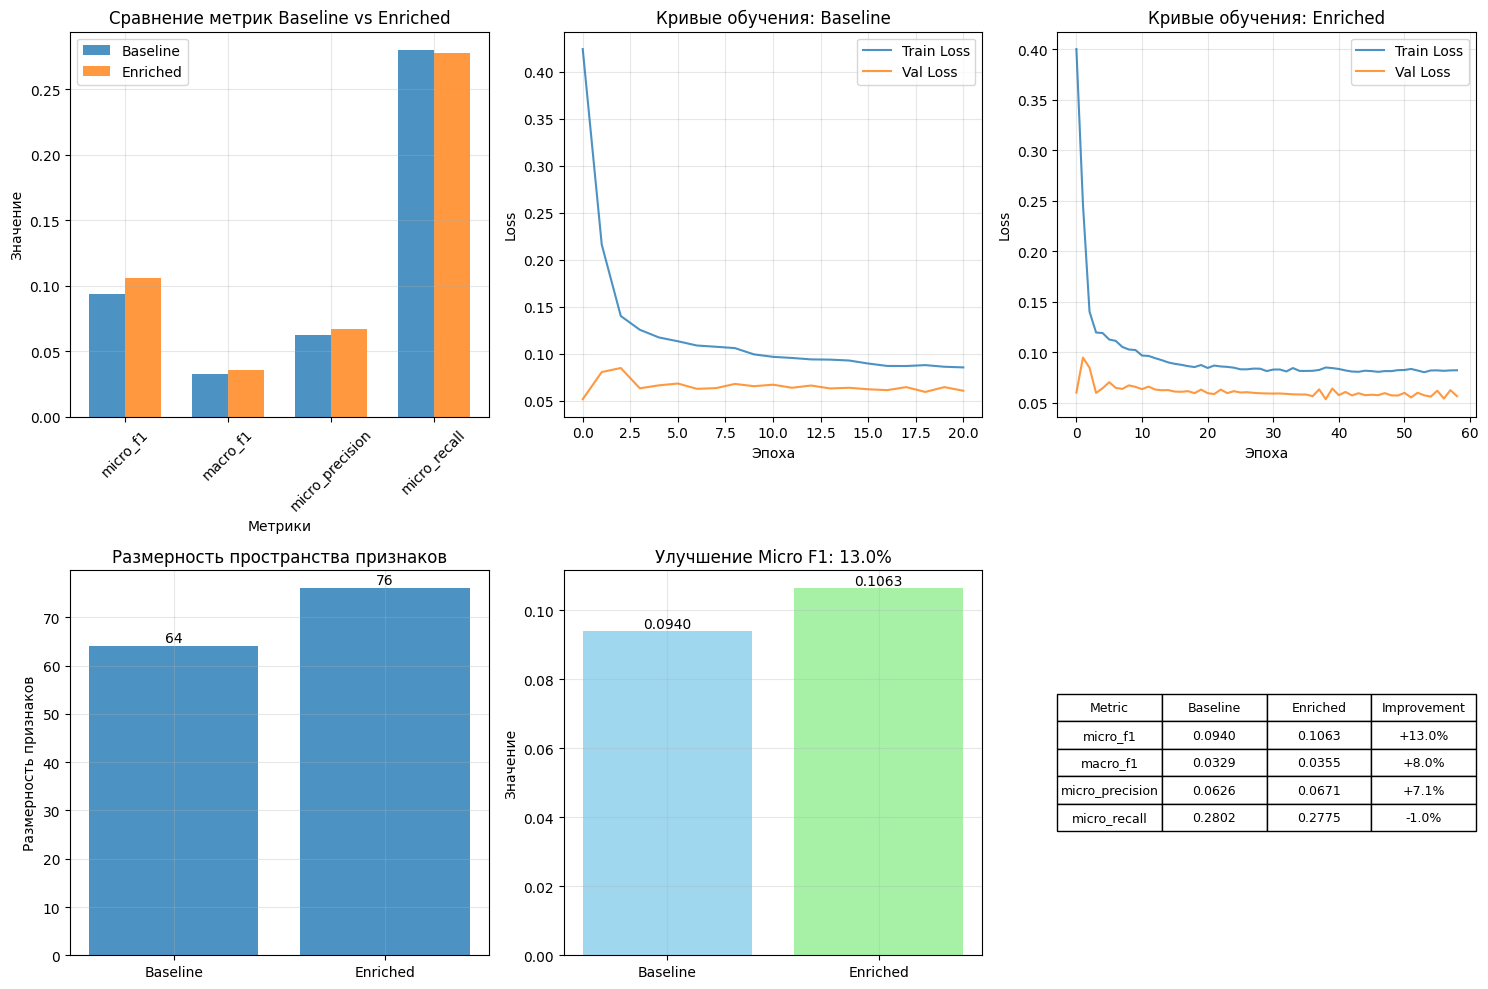


ИТОГОВЫЕ РЕЗУЛЬТАТЫ ЭКСПЕРИМЕНТА
Metric               Baseline     Enriched     Improvement, %
----------------------------------------------------------------------
micro_f1             0.0940       0.1063       +13.0       
macro_f1             0.0329       0.0355       +8.0        
micro_precision      0.0626       0.0671       +7.1        
micro_recall         0.2802       0.2775       -1.0        


In [17]:
pipeline = GeometricMLPipeline(
    embedding_dim=64,  
    hidden_dim=128,    
    heads=4,           
    dropout=0.2       
)

ego_ids = list(enriched_ego_networks.keys())

train_ids, val_ids, test_ids = pipeline.split_ego_networks (ego_ids, train_ratio=0.7, val_ratio=0.15)

results = pipeline.run_experiment (enriched_ego_networks, train_ids, val_ids, test_ids)
pipeline.visualize_results()

In [18]:
results.keys()

dict_keys(['baseline', 'enriched'])

In [20]:
results['baseline']['metrics'].keys()

dict_keys(['micro_f1', 'macro_f1', 'micro_precision', 'micro_recall', 'total_samples', 'num_test_networks', 'per_network_metrics'])